# Project - Problem 2

Implementation of VO

##Self Assesment:

#1) Write a short description about how your obtained the data.
Answer:
  The video I used was recorded at the GWU Fitness Center, which I visit almost every day. I thought it would be interesting to apply visual odometry in a space I am familiar with, and it made the project more engaging for me personally. It was also a good test case with real-world lighting, motion, and structure.



#2) Describe your approaches to tune the paramters and to update the code.
Answer:

  a) My main goals were to ensure robustness, scalability (processing all 1799 frames), and interpretability of results.

  b) Initially, I had a hard time finding a good image pair for bootstrapping — most pairs didn’t have enough 3D points or well-distributed features. To fix this, I wrote a loop that automatically scanned through the first 50 frames and picked the pair with the best keypoint spread and feature count, which made the initialization much more reliable

  c) I tuned the bootstrap parameters to ensure enough keypoints and 3D points could be reliably extracted. I relaxed these thresholds incrementally until a stable initialization was achieved with a good spread of features.

  d) Memory-Efficient Processing
  I split processing into batches and reused variables, garbage collection, and dynamically expanded (T_W) to handle long sequences without Colab memory crashes.

  e) I had to add checks at multiple code snippets to exactly find out which frames are useable or frames which need to be skipped due to noise/ low number of 3D points.



#3) Discuss what was successful and what was not successful.
Answer:
  
  a) Successful:

**End-to-End Pipeline:**
The biggest win was getting the full VO pipeline to work — from feature detection and bootstrap initialization all the way to mapping and visualizing the trajectory across hundreds of frames.

**Parameter Tuning:**
After some trial and error, I managed to find parameter values that worked well for my video. Relaxing thresholds at the right points made a big difference in getting stable results.

**Camera Caliberation:**
For the camera calibration part, I captured a fresh set of checkerboard images specifically for this project. I made sure they matched the resolution and setup of the video frames I was using, so the calibration results would be more accurate and consistent with the rest of the pipeline.

  b) Not Successful:

Processing all **1799** frames was one of the most challenging parts of the project

**Initial Bootstrap Failures:**
Early on, I struggled with bootstrap wframe pairs that didn’t produce enough 3D points.

**Colab Memory Limits:**
Once the pipeline scaled up, memory started becoming a problem — especially when saving a lot of figures or not clearing variables. I had to adjust my approach and clean up memory after every loop iteration to keep things running

**Trajectory Visualization Accuracy**:
While the trajectory shape looks good overall, I suspect there’s some drift or scale ambiguity

#4)Discuss what should be done to improve your results.
Answer:

a) To improve the results, I could use a video with more texture and depth variation, which would help with better keypoint detection and 3D reconstruction. Adding IMU data or using more advanced optimization like bundle adjustment would reduce drift over time. On the implementation side, using better memory management.

b) Further in some cases, the model was detecting unnecessary or irrelevant keypoints — especially in low-texture areas or on flat surfaces where there wasn’t much meaningful visual information. This sometimes led to noisy matches or unstable tracking


**YouTube Video link:
I tried uploading the video with better video quality but it is getting default uploaded as a YouTube short which is compressing my video quality when viewed on a desktop:**

https://youtube.com/shorts/dn3i3iQLkJE?feature=share




## Import Modules

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

# Problem 2 (80pt)

Now, we are going to perform VO for a data set collected by ourselves.
Perform VO as descriubed in Problem 1, and generate the similar outcomes. You can use all of your knowledge learned during this class, and feel free to modify any part of the code.


## Dataset


1. Record a video in a place where many features are availalbe. Make the resolution similar with the KITTI dataset (1241x376) or the parking lot dataset (640x480). Any scene familiar to the class, such as SEH or National Mall, is encouranged, but not required.


2. Recall the following assumptions of VO. Your video should satisfy those.
    * Sufficient illumination
    * Dominance of static background over moving objects
    * Enough unique features to be detected
    * Sufficient overlap between frames




## Tips

* Calibrate your camera first as done in Homework #2. To verify your camera calibration, check if you can generate a virtual 3D cube that looks reasonagle.

* First perform bootstrapping and see if the triangulated points make sense in the world frame. We need sufficiently large baseline to be successful. If needed the bootstratpping can be done with the first and the third or later.

* Then, try localization and mapping using the similar parameters for the first 10 frames. Tune the parameters before trying more frames.

* For robust triangulation, you can implement further error checking to discards keypoints with negative depts or kepoints too far away.

More specifically, the following if statement in `mae6292.VO_localization_mapping` can be updated with additional error check.

```
# If the triangulated p_W is inlier then the corresponding keypoint is added to the state
if index_pW_inliers.shape[0] > 0:
    index_C_pre_matched_inliers.append(i)
    S_keypoints.append((C_p_i[1], C_p_i[0]))
    S_p_W = np.concatenate( (S_p_W, p_W_i), axis=1)
# Otherwise save it with the prior history as a tracked, continuing candidate
else:
    index_C_pre_matched_outliers.append(i)
    C_keypoints.append((C_p_i[1], C_p_i[0]))
    C_keypoints_org.append(C_pre.keypoints_org[i])
    C_R_org.append(C_pre.R_org[i])
    C_T_org.append(C_pre.T_org[i])
```

* Once you make any changed to `mae6292` functions in your text editor, execute `importlib.reload(mae6292)` so that your updates are reloaded to Jupyter.

## How To Submit

* Write a short description about how your obtained the data.
* Generate the following outcomes similar with Problem 1.
    1. `prob2_bootstrap.png`: image showing the results of bootstrapping
    2. `prob2.mp4`: video showing the results of localization and mapping at each frame
    3. `prob2_map.png`: image showing the complete trajectory map
* Describe your approaches to tune the paramters and to update the code.
* Discuss what was successful and what was not successful.
* Discuss what should be done to improve your results.
* See the successful examples from the last year. Reasonable trajectory over longer period will be appreciated.
    * [Self collected data in street](https://www.youtube.com/watch?v=NlpiFpSuur0)
    * [Self-collected data in SEH](https://www.youtube.com/watch?v=kHIouSBPu-w)

* Finally, upload your video to **YouTube** and specify the link.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

frame_dir = "/content/drive/MyDrive/NewVid"
output_dir = "/content/drive/MyDrive/VO_video_output"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.spatial.distance
import importlib

In [ ]:
import zipfile
import os

# Extract mae6292.zip
with zipfile.ZipFile('/MAE6292.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MAE6292up')

# Verify extraction

print("Extracted files:", os.listdir('/content/MAE6292up'))

Extracted files: ['tools.py', '__pycache__', 'imshow.py', '__init__.py']


In [ ]:
import sys
sys.path.append('/content/MAE6292up')

In [ ]:
from MAE6292up.imshow import cv2_imshow
import MAE6292up.tools as mae6292
import glob

In [ ]:
CHECKERBOARD = (9, 6)
square_size = 1.0

objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2) * square_size

objpoints = []
imgpoints = []

calib_images = glob.glob("/content/drive/MyDrive/calib_images/*.jpg")

print(f"Found {len(calib_images)} calibration images.")
import os
os.listdir("/content/drive/MyDrive/calib_images")

for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)


if len(imgpoints) == 0:
    raise ValueError("No checkerboard corners detected .")


last_img = cv2.imread(calib_images[-1])
gray = cv2.cvtColor(last_img, cv2.COLOR_BGR2GRAY)
ret, K_original, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Original K (from calibration resolution):")
print(K_original)

Found 10 calibration images.
Original K (from calibration resolution):
[[3.41165839e+03 0.00000000e+00 1.99677469e+03]
 [0.00000000e+00 3.47693669e+03 6.42733168e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
calib_width = 4000   # Checkerboard Image Width
calib_height = 2252  # Checkerboard Image Height
vo_width = 1280
vo_height = 720

scale_x = vo_width / calib_width
scale_y = vo_height / calib_height

K = K_original.copy()
K[0, 0] *= scale_x
K[1, 1] *= scale_y
K[0, 2] *= scale_x
K[1, 2] *= scale_y

print("Scaled K for VO:")
print(K)


Scaled K for VO:
[[1.09173069e+03 0.00000000e+00 6.38967900e+02]
 [0.00000000e+00 1.11163162e+03 2.05491954e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Detected 1115 Harris corners in img0


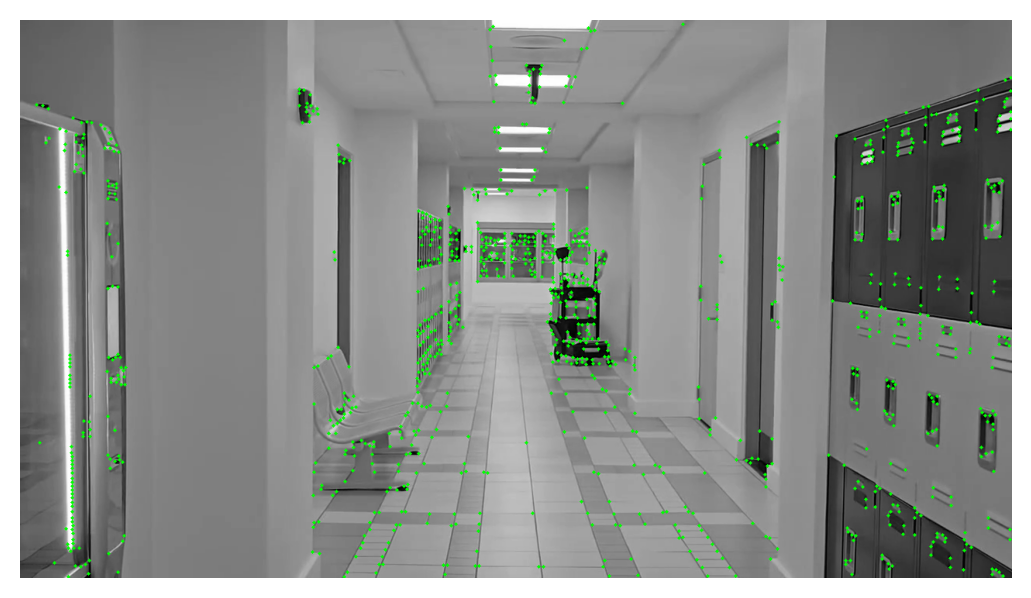

In [ ]:
corners = cv2.goodFeaturesToTrack(img0, maxCorners=3000, qualityLevel=0.01, minDistance=5)
img_debug = cv2.cvtColor(img0.copy(), cv2.COLOR_GRAY2BGR)
if corners is not None:
    for pt in corners:
        x, y = pt[0]
        cv2.circle(img_debug, (int(x), int(y)), 2, (0, 255, 0), -1)
    print(f"Detected {len(corners)} Harris corners in img0")
else:
    print("No corners detected in img0")
cv2_imshow(img_debug)

In [ ]:
param_bootstrap = {
    'W_harris_patch': 5,
    'kappa_harris': 0.04,
    'N_keypoint': 3000,
    'W_nms': 4,
    'W_KLT': 5,
    'tol_KLT_bidir': 4,
    'tol_E': 7,
    'tol_E_RANSAC_prob': 0.97,
    'tol_TRI_mu': 3e-3,
    'tol_TRI_rep': 4
}

best_score = -1
best_pair = None
best_kp = None
best_pw = None

print(" Searching best bootstrap pair")

for i in range(1, 30):
    img0 = cv2.imread(f"{frame_dir}/img_{i:05d}.png", cv2.IMREAD_GRAYSCALE)
    img1 = cv2.imread(f"{frame_dir}/img_{i+1:05d}.png", cv2.IMREAD_GRAYSCALE)

    if img0 is None or img1 is None:
        print(f" Skipping frames {i}-{i+1}.")
        continue

    kp, pw, R1, T1 = mae6292.VO_bootstrap(img0, img1, K, param_bootstrap, display=False)

    print(f"Frames {i}-{i+1}: {len(kp)} keypoints, {pw.shape[1]} 3D points")

    if len(kp) < 50 or pw.shape[1] < 8:
        print(f" Skipped .")
        continue

    # Spread score
    arr = np.array(kp)
    spread = np.std(arr, axis=0).sum()

    if spread > best_score:
        best_score = spread
        best_pair = (i, i+1)
        best_kp, best_pw = kp, pw
        selected_R1, selected_T1 = R1, T1
        print(f" best pair: {i}-{i+1} with spread {spread:.2f}")

if best_pair is None:
    raise RuntimeError(" No suitable bootstrap pair found.")

print(f"\n Best bootstrap pair: {best_pair[0]} & {best_pair[1]}")
print(f"  Keypoints: {len(best_kp)}")
print(f"  Triangulated 3D points: {best_pw.shape[1]}")

# Store output
img0 = cv2.imread(f"{frame_dir}/img_{best_pair[0]:05d}.png", cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread(f"{frame_dir}/img_{best_pair[1]:05d}.png", cv2.IMREAD_GRAYSCALE)
keypoints0 = best_kp
p_W0 = best_pw
R1 = selected_R1
T1 = selected_T1


In [ ]:
img_vis = cv2.cvtColor(img0.copy(), cv2.COLOR_GRAY2BGR)

for pt in keypoints0:
    x, y = int(pt[0]), int(pt[1])
    cv2.circle(img_vis, (x, y), 2, (0, 255, 0), -1)

print(f" Visualizing {len(keypoints0)} bootstrap keypoints on frame {best_pair[0]}")


from MAE6292up.imshow import cv2_imshow
cv2_imshow(img_vis)

In [ ]:
param_mapping = {
    'W_harris_patch': 5,
    'kappa_harris': 0.04,
    'N_keypoint': 3000,
    'W_nms': 6,
    'W_KLT': 5,
    'tol_KLT_bidir': 3,
    'tol_TRI_mu': 2e-3,
    'tol_TRI_rep': 3,
    'tol_keypoints_new': 10
}


In [ ]:

T_W = np.zeros((3, 1000))
T_W[:, best_pair[1]] = np.zeros((3,))  # initial camera position

img_pre = img0
S_pre = mae6292.state(keypoints0, p_W0, [np.zeros((3,1))])
C_pre = mae6292.candidate([],[],[],[])

batch_start = 1718  # Start frame
batch_size = 100
start_frame = batch_start
N_frames = min(batch_start + batch_size - 1, len([f for f in os.listdir(frame_dir) if f.endswith(".png")]) - 1)
p_W = p_W0

skipped_frames = []
processed_frames = []

import time

print(" number of 3D points in p_W0:", p_W0.shape[1])

for i_frame in range(start_frame, N_frames + 1):
    start_time = time.time()

    if S_pre.p_W.shape[1] < 4:
        print(f" Frame {i_frame:05d} skipped ({S_pre.p_W.shape[1]}).")
        skipped_frames.append(i_frame)
        continue

    print(f"Processing frame {i_frame:05d}...")
    processed_frames.append(i_frame)

    img_path = f"{frame_dir}/img_{i_frame:05d}.png"
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.imread(img_path)

    if img is None or img_color is None:
        print(f" Frame {i_frame:05d} — image not found: {img_path}")
        skipped_frames.append(i_frame)
        continue

    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

    try:
        R, T, S, C, fig = mae6292.VO_localization_mapping(
            i_frame, img, img_rgb, img_pre, S_pre, C_pre, K, param_mapping, display_process=True
        )
    except Exception as e:
        print(f" Frame {i_frame:05d} failed: {e}")
        skipped_frames.append(i_frame)
        continue

    if R is None or T is None or S is None:
        print(f" Frame {i_frame:05d} returned None for R, T, or S. Skip.")
        skipped_frames.append(i_frame)
        continue

    img_pre, S_pre, C_pre = img, S, C

    if i_frame >= T_W.shape[1]:
        expand_cols = i_frame - T_W.shape[1] + 100
        print(f" Expanding T_W by {expand_cols} columns at frame {i_frame}")
        T_W = np.pad(T_W, ((0, 0), (0, expand_cols)), mode='constant')


    T_W[:, i_frame] = (-R.T @ T).flatten()

    p_W_dist = scipy.spatial.distance.cdist(S.p_W.T, p_W.T, )
    index_distinct = np.where(np.min(p_W_dist, axis=1) > 3)[0]
    p_W = np.append(p_W, S.p_W[:, index_distinct], axis=1)

    if fig is not None:
        fig.savefig(f"{output_dir}/frame_{i_frame:05d}.png")
        plt.close(fig)
    else:
        print(f" Skipped saving figure for frame {i_frame:05d} — fig is None.")

    if i_frame % 100 == 0:
        np.save(f"{output_dir}/T_W_partial_{i_frame}.npy", T_W)
        np.save(f"{output_dir}/p_W_partial_{i_frame}.npy", p_W)
        print(f" Progress saved at frame {i_frame}")

    print(f" Frame {i_frame:05d} completed in {time.time() - start_time:.2f} sec")


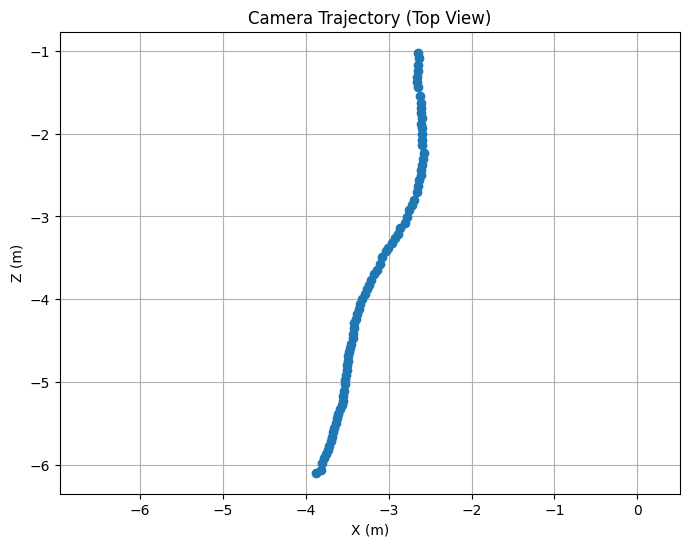

In [ ]:
import matplotlib.pyplot as plt


valid_indices = np.where(np.linalg.norm(T_W, axis=0) != 0)[0]
trajectory = T_W[:, valid_indices]

plt.figure(figsize=(8, 6))
plt.plot(trajectory[0], trajectory[2], marker='o', linewidth=1)
plt.xlabel("X (m)")
plt.ylabel("Z (m)")
plt.title("Camera Trajectory (Top View)")
plt.grid(True)
plt.axis('equal')
plt.show()


In [ ]:
import os

output_dir = "/content/drive/MyDrive/VO_clr_out"
os.makedirs(output_dir, exist_ok=True)


In [ ]:
!ffmpeg -framerate 10 -start_number 26 -i /content/drive/MyDrive/VO_video_output/frame_%05d.png \
-c:v libx264 -pix_fmt yuv420p /content/drive/MyDrive/VO_clr_out/vo_output_colorfinal.mp4
